# Earthquake counting process — station-level explorer

This notebook loads `comcat_metadata.csv`, lets you pick a year and a station (or auto-select the most active station for that year), and displays a counting process (cumulative count) of earthquake events for that station and year.

Change the parameters in the first code cell and re-run the subsequent cells.


In [1]:
# Parameters and imports
csv_path = 'comcat_metadata.csv'  # relative to this notebook
year = 2010                      # year to analyze
station = None                   # set to a station code like 'B203' to force; None auto-selects top station
top_n = 20                       # how many top stations to show
chunksize = 200000               # chunk size for reading large CSV
save_csv = False                  # if True, will save filtered station CSV (not enabled by default)
save_plot = False                 # set True to also write plot to disk

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from IPython.display import display

sns.set(style='whitegrid')

p = Path(csv_path)
if not p.exists():
    raise FileNotFoundError(f"CSV not found at {p.resolve()}; put `comcat_metadata.csv` next to this notebook.")
print('Parameters: ', dict(csv_path=csv_path, year=year, station=station, top_n=top_n))


Parameters:  {'csv_path': 'comcat_metadata.csv', 'year': 2010, 'station': None, 'top_n': 20}


In [2]:
# Preview CSV: show columns and a few sample rows (fast)
df_head = pd.read_csv(p, nrows=6)
print('Columns ({}):'.format(len(df_head.columns)))
for c in df_head.columns:
    print(' -', c)

display(df_head)


Columns (37):
 - event_id
 - source_origin_time
 - source_latitude_deg
 - source_longitude_deg
 - source_type
 - source_depth_km
 - preferred_source_magnitude
 - preferred_source_magnitude_type
 - preferred_source_magnitude_uncertainty
 - source_depth_uncertainty_km
 - source_horizontal_uncertainty_km
 - station_network_code
 - station_channel_code
 - station_code
 - station_location_code
 - station_latitude_deg
 - station_longitude_deg
 - station_elevation_m
 - trace_name
 - trace_sampling_rate_hz
 - trace_start_time
 - trace_S_arrival_sample
 - trace_P_arrival_sample
 - trace_S_arrival_uncertainty_s
 - trace_P_arrival_uncertainty_s
 - trace_P_polarity
 - trace_S_onset
 - trace_P_onset
 - trace_snr_db
 - source_type_pnsn_label
 - source_local_magnitude
 - source_local_magnitude_uncertainty
 - source_duration_magnitude
 - source_duration_magnitude_uncertainty
 - source_hand_magnitude
 - trace_missing_channel
 - trace_has_offset


,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,preferred_source_magnitude_uncertainty,source_depth_uncertainty_km,...,trace_P_onset,trace_snr_db,source_type_pnsn_label,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset
0,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.1,md,0.03,1.68,...,NaN,6.135|3.065|11.766,eq,NaN,NaN,2.1,0.03,NaN,0,1
1,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.1,md,0.03,1.68,...,NaN,nan|nan|22.583,eq,NaN,NaN,2.1,0.03,NaN,2,0
2,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.1,md,0.03,1.68,...,NaN,1.756|3.057|3.551,eq,NaN,NaN,2.1,0.03,NaN,0,1
3,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.1,md,0.03,1.68,...,NaN,nan|nan|27.185,eq,NaN,NaN,2.1,0.03,NaN,2,0
4,uw10568748,2002-09-26T07:00:04.860000Z,48.481,-123.133,earthquake,22.748,2.9,md,0.03,0.91,...,NaN,10.881|17.107|2.242,eq,NaN,NaN,2.9,0.03,NaN,0,1
5,uw10568748,2002-09-26T07:00:04.860000Z,48.481,-123.133,earthquake,22.748,2.9,md,0.03,0.91,...,NaN,29.412|30.57|29.827,eq,NaN,NaN,2.9,0.03,NaN,0,0


In [3]:
# Chunked scan: count station codes in the chosen year (memory-safe)
counts = Counter()
usecols = ['source_origin_time','station_code']
for i, chunk in enumerate(pd.read_csv(p, usecols=usecols, parse_dates=['source_origin_time'], chunksize=chunksize, low_memory=True)):
    chunk = chunk.dropna(subset=['source_origin_time','station_code'])
    chunk['year'] = chunk['source_origin_time'].dt.year
    cyear = chunk[chunk['year'] == year]
    if not cyear.empty:
        counts.update(cyear['station_code'].astype(str))
    if i % 5 == 0:
        print(' processed chunk', i)

most_common = counts.most_common(top_n)
print('\nTop stations in', year, '(station_code, count):')
for st, cnt in most_common:
    print(st, cnt)


 processed chunk 0

Top stations in 2010 (station_code, count):
B203 272
ELK 257
B202 238
HDW 220
FL2 204
B943 199
B013 194
B204 193
LVP 177
B941 157
HTW 144
JCW 118
STAR 116
YACT 112
TOLT 111
B018 105
TDL 98
GNW 96
RPW 85
BLN 85


In [4]:
# Extract events for chosen station and year, assembling via chunks
if not most_common:
    print(f'No events found in {year}. Nothing to extract.')
else:
    if station is None:
        station = most_common[0][0]
        print(f'No station selected — defaulting to most active station: {station}')
    else:
        print(f'Filtering for station: {station}')

    sel_frames = []
    for i, chunk in enumerate(pd.read_csv(p, parse_dates=['source_origin_time'], chunksize=chunksize, low_memory=True)):
        chunk = chunk.dropna(subset=['source_origin_time','station_code'])
        chunk['year'] = chunk['source_origin_time'].dt.year
        sel = chunk[(chunk['year'] == year) & (chunk['station_code'].astype(str) == str(station))]
        if not sel.empty:
            sel_frames.append(sel)
    
    if not sel_frames:
        df_sel = pd.DataFrame()
        print('No rows found for that station/year.')
    else:
        df_sel = pd.concat(sel_frames, ignore_index=True)
        # robustly parse time and sort
        df_sel['source_origin_time'] = pd.to_datetime(df_sel['source_origin_time'], utc=True, errors='coerce')
        df_sel = df_sel.dropna(subset=['source_origin_time']).sort_values('source_origin_time')
        display(df_sel.head())
        print('\nSelected rows:', df_sel.shape)

        if save_csv:
            outp = Path(f'selected_{station}_{year}.csv')
            df_sel.to_csv(outp, index=False)
            print('Saved filtered CSV to', outp.resolve())


No station selected — defaulting to most active station: B203


,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,preferred_source_magnitude_uncertainty,source_depth_uncertainty_km,...,trace_snr_db,source_type_pnsn_label,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,year
225,uw10782593,2010-01-01 16:12:44.300000+00:00,45.886,-122.201,earthquake,4.030,1.55,ml,0.153,0.86,...,23.444|29.653|22.248,eq,1.55,0.153,1.6,0.04,NaN,0,0,2010
224,uw10782813,2010-01-03 05:30:44.940000+00:00,46.182,-122.292,earthquake,9.401,1.05,ml,0.180,0.92,...,30.377|35.782|27.353,eq,1.05,0.180,0.7,0.02,NaN,0,0,2010
223,uw10783343,2010-01-04 03:26:58.170000+00:00,46.015,-122.376,earthquake,15.279,0.67,ml,0.195,0.28,...,16.569|17.366|10.628,eq,0.67,0.195,0.5,0.03,NaN,0,0,2010
222,uw10783988,2010-01-04 17:58:19.250000+00:00,46.454,-122.225,earthquake,16.282,1.70,ml,0.125,0.54,...,32.998|31.256|27.282,eq,1.70,0.125,0.9,0.03,NaN,0,0,2010
221,uw10784658,2010-01-06 00:54:33.580000+00:00,46.193,-122.299,earthquake,9.861,1.22,ml,0.182,0.12,...,35.658|38.851|31.797,eq,1.22,0.182,0.9,0.02,NaN,0,0,2010



Selected rows: (272, 38)


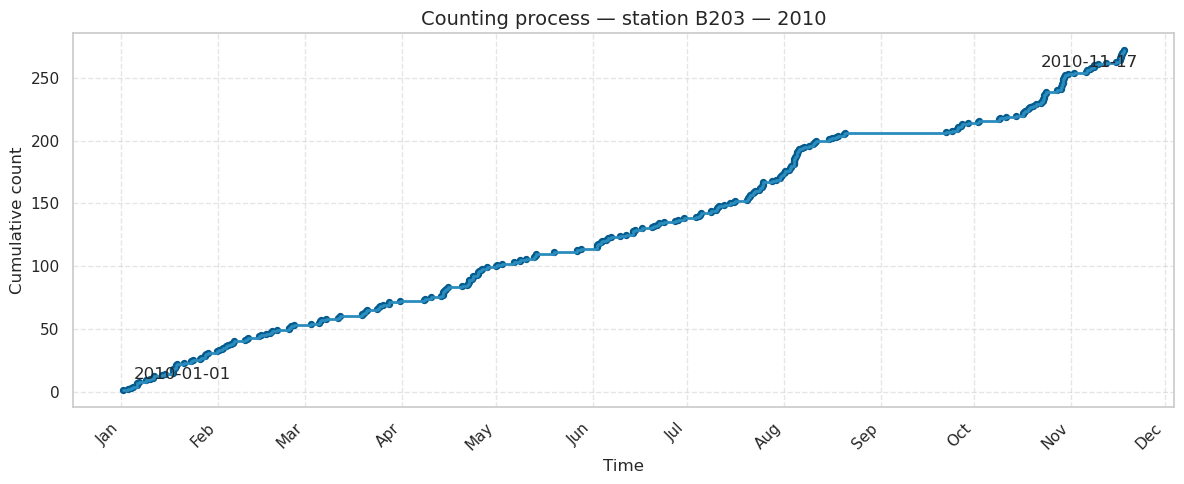

In [5]:
# Plot counting process inline (no files written by default)
import matplotlib.dates as mdates
if 'df_sel' not in globals() or df_sel.empty:
    print('No data to plot. Make sure df_sel has data (run the previous cell).')
else:
    df_sel = df_sel.reset_index(drop=True)
    df_sel['count'] = range(1, len(df_sel)+1)

    fig, ax = plt.subplots(figsize=(12,5))
    ax.step(df_sel['source_origin_time'], df_sel['count'], where='post', linewidth=2, color='#2b8cbe')
    ax.scatter(df_sel['source_origin_time'], df_sel['count'], s=18, color='#045a8d')

    ax.set_title(f'Counting process — station {station} — {year}', fontsize=14)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Cumulative count', fontsize=12)

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # annotate start and end
    start = df_sel['source_origin_time'].iloc[0]
    end = df_sel['source_origin_time'].iloc[-1]
    ax.annotate(start.strftime('%Y-%m-%d'), xy=(start, 1), xytext=(8,8), textcoords='offset points')
    ax.annotate(end.strftime('%Y-%m-%d'), xy=(end, df_sel['count'].iloc[-1]), xytext=(-60,-12), textcoords='offset points')

    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    if save_plot:
        out_dir = Path('plots')
        out_dir.mkdir(exist_ok=True)
        out_file = out_dir / f'counting_{station}_{year}.png'
        fig.savefig(out_file, dpi=200, bbox_inches='tight')
        print('Saved plot to', out_file.resolve())


**Usage notes**

- Change the parameters at the top (year, station) and re-run cells.
- The CSV is read in chunks for memory-safety. If you want faster runs for the same station/year, set `save_csv=True` once to write a filtered CSV and then work from that smaller file.
- If you want the plot saved automatically, set `save_plot=True`.
